# Load Data

## Import Libraries

In [ ]:
# Import pandas, numpy, math and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# seaborn is a data visualization library built on matplotlib
import seaborn as sns

# set the plotting style
sns.set_style("whitegrid")

## Load Diabetes Datasets

### Diabetes 130-US Hospitals for Years 1999-2008




In [ ]:
# Loading dataset
diabetic_UCI = pd.read_csv("https://raw.githubusercontent.com/data5100-group/diabetes-risk-analysis/main/data/diabetic_data.csv")

# Loading mapping
ids_mapping_UCI = pd.read_csv("https://raw.githubusercontent.com/data5100-group/diabetes-risk-analysis/main/data/IDS_mapping.csv")


### Comprehensive Diabetes Clinical Dataset

In [ ]:
# Loading dataset
diabetes_kaggle = pd.read_csv("https://raw.githubusercontent.com/data5100-group/diabetes-risk-analysis/main/data/diabetes_dataset.csv")


## Understand the Data

In [ ]:
diabetes_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [ ]:
diabetic_UCI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# Clean the Datasets

## Columns to Keep

In [ ]:
diabetic_UCI = diabetic_UCI[[
    # Identifiers: One patient number can have multiple encounter ids
   "encounter_id", "patient_nbr",

    # Demographics
    "race", "gender", "age",

    # Admission/Discharge info
    "admission_type_id", "discharge_disposition_id", "admission_source_id",

    # Hospital Stay/ Utilization
    "time_in_hospital", "num_medications",
    "number_outpatient", "number_emergency", "number_inpatient",

    # Diagnosis Codes
    "diag_1", "diag_2", "diag_3", "number_diagnoses",

    # Medication Information
    "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
    "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone",
    "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide",
    "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone",
    "metformin-rosiglitazone", "metformin-pioglitazone", "change", "diabetesMed",

    # Outcome
    "readmitted"
]]

In [ ]:
diabetes_kaggle = diabetes_kaggle[[
    # Demographics
    "age", "gender", "race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Other",

    # Factors
    "hypertension", "heart_disease", "smoking_history", "bmi", "hbA1c_level", "blood_glucose_level",

    # Outcome
    "diabetes"
]]

## Recombine diabetic_UCI and ids_mapping_UCI

In [ ]:
first, second = ids_mapping_UCI.columns[:2]

m = ids_mapping_UCI.copy()
m[first] = m[first].astype(str).str.strip()

SECS = ["admission_type_id", "discharge_disposition_id", "admission_source_id"]

# Mark section rows only where the cell equals a section name
m["section"] = m[first].where(m[first].isin(SECS)).ffill()

# The top block in the CSV admission_type_id has no explicit marker row,
# so fill any remaining NAs with the first section name.
m["section"] = m["section"].fillna("admission_type_id")

# Keep only the three sections we care about
m = m[m["section"].isin(SECS)].copy()

# Keep only numeric ID rows within each section
m["id_num"] = pd.to_numeric(m[first], errors="coerce")
m = m[m["id_num"].notna()].copy()
m["id_num"] = m["id_num"].astype(int)

# Build dicts per section
maps = {sec: dict(zip(g["id_num"], g[second])) for sec, g in m.groupby("section")}
print("Mapping sizes:", {k: len(v) for k, v in maps.items()})

# Replace codes in-place in the main dataframe
for col in SECS:
    mp = maps.get(col, {})
    diabetic_UCI[col] = (
        pd.to_numeric(diabetic_UCI[col], errors="coerce")
          .astype("Int64")
          .map(mp)
          .astype("string")
    )

Mapping sizes: {'admission_source_id': 25, 'admission_type_id': 8, 'discharge_disposition_id': 30}


In [ ]:
# Rename Columns without "id"
diabetic_UCI = diabetic_UCI.rename(columns={
    "admission_type_id": "admission_type",
    "discharge_disposition_id": "discharge_disposition",
    "admission_source_id": "admission_source",
})

# Exporting CSVs

In [ ]:
# Turn the cleaned datasets to CSVs
diabetic_UCI.to_csv(
    'diabetic_UCI',
    encoding='utf-8-sig',
    index=False
)

diabetes_kaggle.to_csv(
    'diabetes_kaggle',
    encoding='utf-8-sig',
    index=False
)

In [ ]:
# Download datasets
from google.colab import files

files.download('diabetic_UCI')
files.download('diabetes_kaggle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Handling Missing Values

In [ ]:
diabetic_UCI.head()

,encounter_id,patient_nbr,race,gender,age,admission_type,discharge_disposition,admission_source,time_in_hospital,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),<NA>,Not Mapped,Physician Referral,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),Emergency,Discharged to home,Emergency Room,3,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),Emergency,Discharged to home,Emergency Room,2,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),Emergency,Discharged to home,Emergency Room,2,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),Emergency,Discharged to home,Emergency Room,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
diabetes_kaggle.head()

,age,gender,race:AfricanAmerican,race:Asian,race:Caucasian,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,32.0,Female,0,0,0,1,0,0,never,27.32,5.0,100,0
1,29.0,Female,0,1,0,0,0,0,never,19.95,5.0,90,0
2,18.0,Male,0,0,0,1,0,0,never,23.76,4.8,160,0
3,41.0,Male,0,0,1,0,0,0,never,27.32,4.0,159,0
4,52.0,Female,1,0,0,0,0,0,never,23.75,6.5,90,0


In [ ]:
diabetic_UCI.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,0
gender,0
age,0
admission_type,5291
discharge_disposition,3691
admission_source,6781
time_in_hospital,0
num_medications,0


During the data cleaning process, we identified missing values in the following categorical variables:
- `admission_type`  5,291
- `discharge_disposition` | 3,691
- `admission_source`  6,781

In [ ]:
diabetes_kaggle.isnull().sum()

,0
age,0
gender,0
race:AfricanAmerican,0
race:Asian,0
race:Caucasian,0
race:Other,0
hypertension,0
heart_disease,0
smoking_history,0
bmi,0


To handle missing values in the admission-related categorical variables,  
we filled all `NaN` entries with the placeholder `"Unknown"` instead of removing rows.  
This helps preserve data while still allowing models to treat missing categories distinctly.

In [ ]:
diabetic_UCI['admission_type'].fillna('Unknown', inplace=True)
diabetic_UCI['discharge_disposition'].fillna('Unknown', inplace=True)
diabetic_UCI['admission_source'].fillna('Unknown', inplace=True)

/tmp/ipython-input-1074567458.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  diabetic_UCI['admission_type'].fillna('Unknown', inplace=True)
/tmp/ipython-input-1074567458.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

Since these columns represent categorical features describing patient admission details, dropping the rows would lead to unnecessary data loss. Therefore, we decided to fill the missing values with `"Unknown"` to preserve the dataset’s completeness.

In [ ]:
diabetic_UCI[['admission_type','discharge_disposition','admission_source']].isnull().sum()

,0
admission_type,0
discharge_disposition,0
admission_source,0


In [ ]:
diabetic_UCI.isnull().sum().sum()

np.int64(0)

In [ ]:
diabetes_kaggle.isnull().sum().sum()

np.int64(0)

This confirms that all missing values have been successfully handled.
The dataset is now fully cleaned and ready for exploratory data analysis (EDA).

## 📊 Exploratory Data Analysis – Diabetes Kaggle Dataset

The goal for this dataset is to explore which **demographic and clinical factors** are related  
to whether a person has diabetes (`diabetes = 1`) or not (`diabetes = 0`).

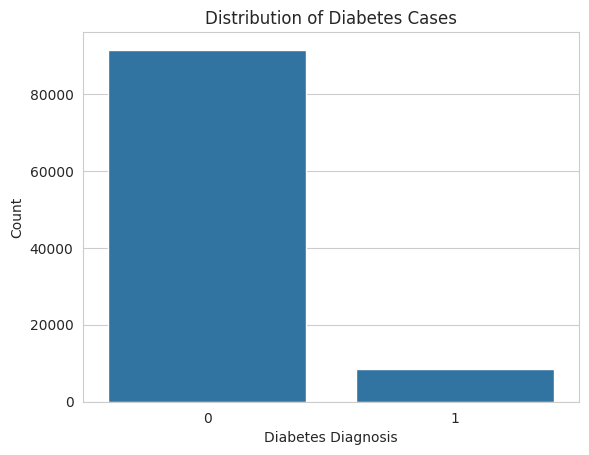

In [ ]:
sns.countplot(x='diabetes', data=diabetes_kaggle)
plt.title('Distribution of Diabetes Cases')
plt.xlabel('Diabetes Diagnosis')
plt.ylabel('Count')
plt.show()

### Categorical Variables vs. Diabetes

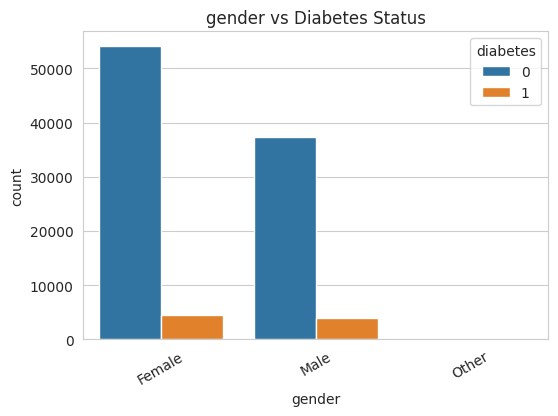

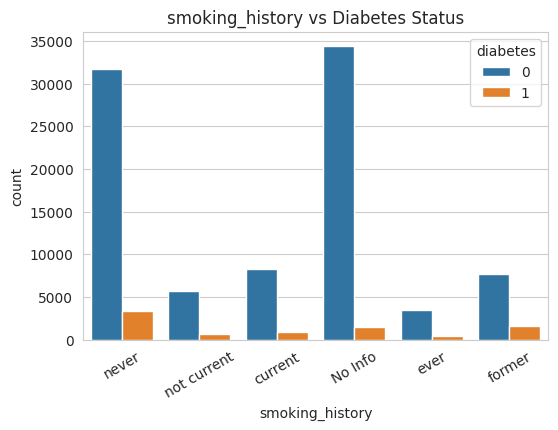

In [ ]:
categorical_cols = ['gender', 'smoking_history']

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='diabetes', data=diabetes_kaggle)
    plt.title(f'{col} vs Diabetes Status')
    plt.xticks(rotation=30)
    plt.show()


#### Correlation Heatmap

We first select only the numeric columns to avoid errors from categorical variables.  
Then we plot the correlation matrix to see relationships between continuous variables.


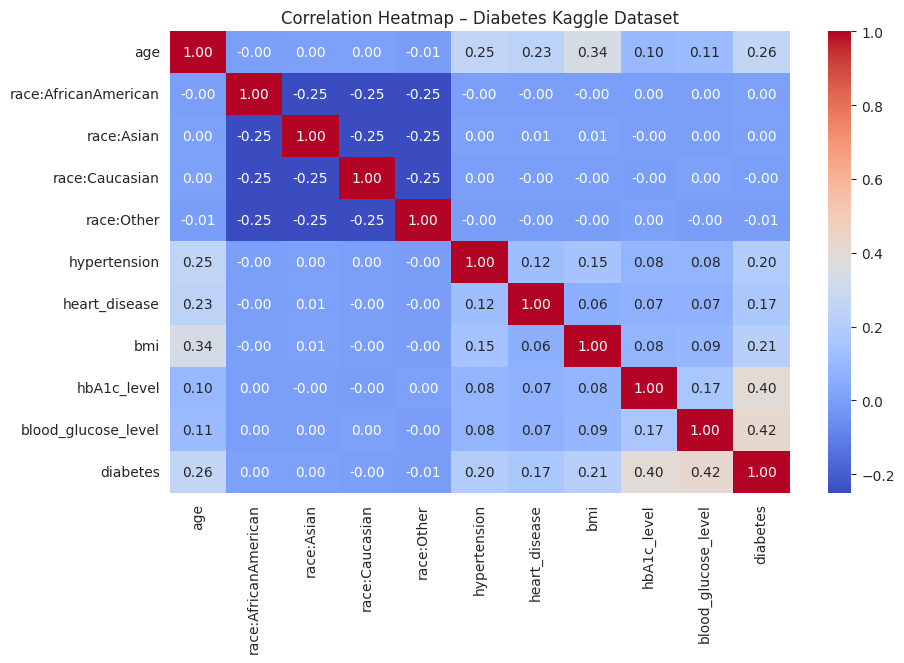

In [ ]:
# Select only numeric columns
numeric_data = diabetes_kaggle.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
corr = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap – Diabetes Kaggle Dataset')
plt.show()

## 🏥 Exploratory Data Analysis – Diabetic UCI Dataset

The goal of this section is to understand which demographic, clinical, and treatment-related factors  
are associated with **hospital readmission** among diabetic patients.

#### Readmission Distribution
We start by checking how often patients are readmitted within 30 days, after 30 days, or not at all.


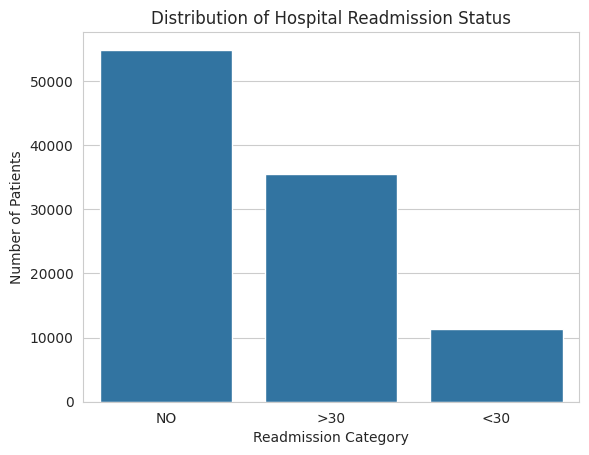

In [ ]:
sns.countplot(x='readmitted', data=diabetic_UCI,
              order=['NO', '>30', '<30'])
plt.title('Distribution of Hospital Readmission Status')
plt.xlabel('Readmission Category')
plt.ylabel('Number of Patients')
plt.show()

#### Demographic Overview

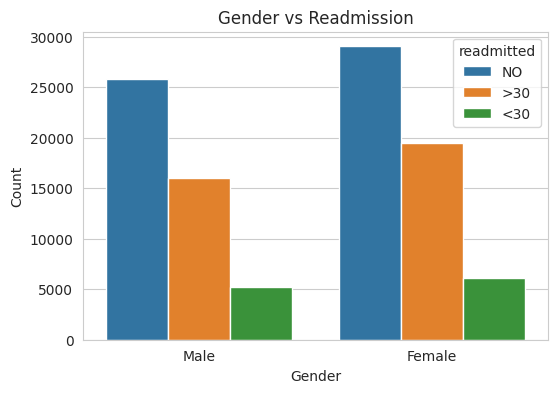

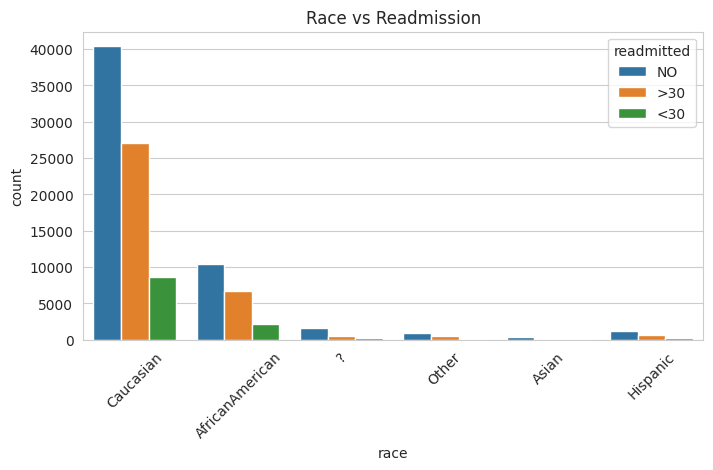

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', hue='readmitted', data=diabetic_UCI,
              order=['Male','Female'])
plt.title('Gender vs Readmission')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='race', hue='readmitted', data=diabetic_UCI)
plt.title('Race vs Readmission')
plt.xticks(rotation=45)
plt.show()

Treatment Factors (Insulin and Medication Changes)

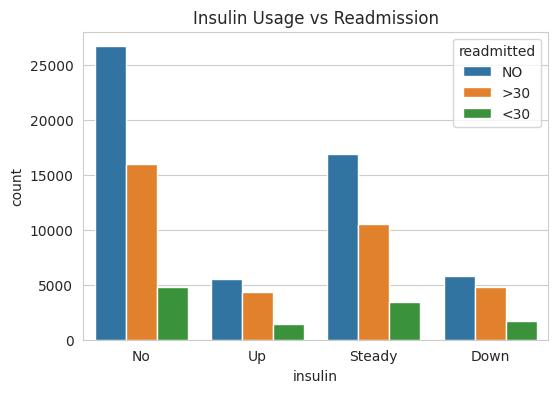

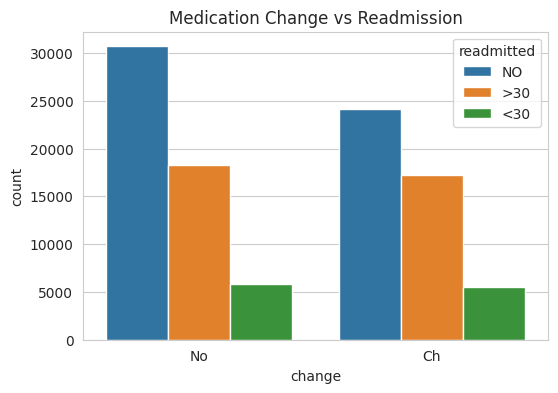

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='insulin', hue='readmitted', data=diabetic_UCI)
plt.title('Insulin Usage vs Readmission')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='change', hue='readmitted', data=diabetic_UCI)
plt.title('Medication Change vs Readmission')
plt.show()


Correlation Heatmap for Numeric Variables

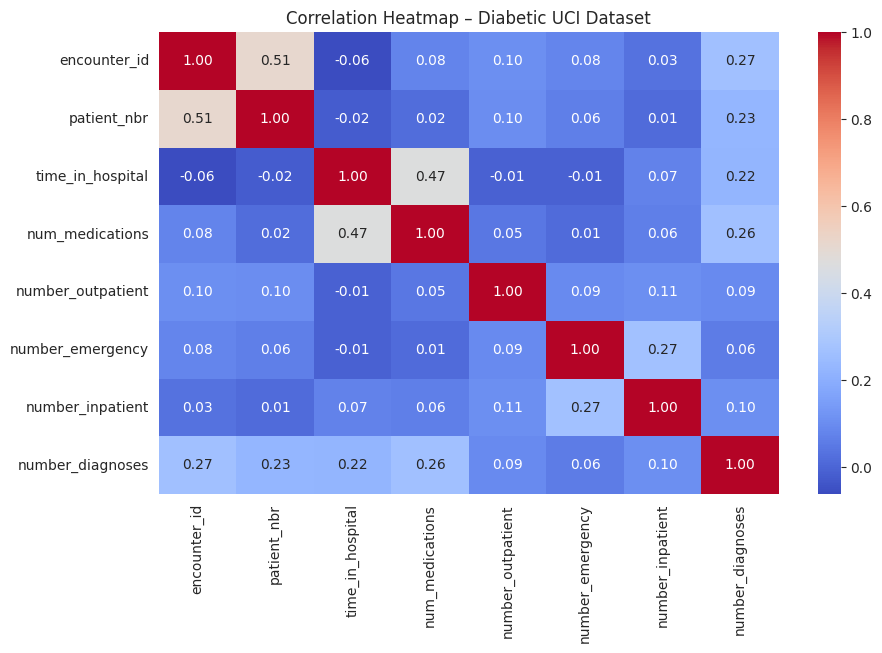

In [ ]:
numeric_data = diabetic_UCI.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap – Diabetic UCI Dataset')
plt.show()


## Statistical and Predictive Modeling
According to our proposal, this section combines statistical testing and simple predictive modeling  
to identify significant predictors in both datasets and compare overlapping risk factors.

## Modeling Question

### Step 7: Modeling Question

Our modeling stage focuses on exploring two major aspects of diabetes care using both datasets.

**Part 1 – Kaggle Dataset (Clinical Factors):**  
Since demographic variables (such as age or gender) were not strong predictors in our earlier models,
we focus on more clinically relevant factors that directly influence diabetes risk.  
Our question is:  
**How do key clinical factors such as BMI, HbA1c level, hypertension, and heart disease relate to patients’ blood glucose levels?**  
We use multiple correlation analysis and linear regression models to identify which variables are most strongly associated with blood glucose level.

**Part 2 – UCI Dataset (Hospital Readmission Patterns):**  
In the hospital dataset, our question is:  
**Which clinical or hospital-related variables best predict whether a diabetic patient is readmitted within 30 days?**  
We explore relationships between variables such as time in hospital, number of medications, and number of lab procedures with readmission status to identify patterns that could inform hospital management and patient care.

Both parts together provide a comparative view of diabetes management, connecting
clinical health indicators with hospital outcomes.


Modeling Question (UCI Dataset)
In this section, we analyze the hospital dataset to understand factors related to readmission among diabetic patients.

Our goal is to identify which factors are associated with **longer hospital stays**,
which can increase the risk of **readmission** and reflect the overall management challenges
in diabetes care.

We focus on numeric variables that represent treatment intensity and hospital utilization:
- **num_medications**
- **number_inpatient**
- **number_emergency**
- **number_outpatient**
- **number_diagnoses**

These variables capture how frequently diabetic patients interact with the healthcare system
and how complex their treatment patterns are.  

We use multiple correlation analysis and multiple linear regression to explore
how these predictors relate to `time_in_hospital` and to highlight potential patterns
that may contribute to readmission among diabetic patients.

Correlation Analysis

In [ ]:
diabetic_UCI.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type', 'discharge_disposition', 'admission_source',
       'time_in_hospital', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [ ]:
# Select numeric variables related to hospital and treatment factors
uci_correlation_vars = diabetic_UCI[['time_in_hospital',
                              'num_medications',
                              'number_inpatient',
                              'number_emergency',
                              'number_outpatient',
                              'number_diagnoses']]

# Calculate correlation matrix
uci_correlation = uci_corr_vars.corr()

# Display correlation matrix
uci_correlation


,time_in_hospital,num_medications,number_inpatient,number_emergency,number_outpatient,number_diagnoses
time_in_hospital,1.000000,0.466135,0.073623,-0.009681,-0.008916,0.220186
num_medications,0.466135,1.000000,0.064194,0.013180,0.045197,0.261526
number_inpatient,0.073623,0.064194,1.000000,0.266559,0.107338,0.104710
number_emergency,-0.009681,0.013180,0.266559,1.000000,0.091459,0.055539
number_outpatient,-0.008916,0.045197,0.107338,0.091459,1.000000,0.094152
number_diagnoses,0.220186,0.261526,0.104710,0.055539,0.094152,1.000000


This correlation analysis is performed on patients who have already been diagnosed with diabetes.  
We explore how hospital and treatment-related factors are related to the length of hospital stay,
which can reflect the complexity of diabetes management.

We expect:
- time_in_hospital to have a positive correlation with num_medications and number_inpatient,
  since diabetic patients who require more medications or repeated admissions often have
  more severe or poorly controlled conditions.
- number_diagnoses may also be correlated with hospital stay, indicating multiple diabetes-related complications.

By analyzing these patterns among diabetic patients, we gain insight into the hospital care
factors that contribute to longer stays and potentially higher readmission risk.

In [ ]:
# Define predictors (X) and target (y)
X = diabetic_UCI[['num_medications', 'number_inpatient',
                  'number_emergency', 'number_outpatient',
                  'number_diagnoses']]
y = diabetic_UCI['time_in_hospital']

# Add constant term
X = sm.add_constant(X)

# Fit multiple linear regression model
uci_model = sm.OLS(y, X).fit()

# Display model summary
print(uci_model.summary())


                            OLS Regression Results                            
Dep. Variable:       time_in_hospital   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     6130.
Date:                Mon, 03 Nov 2025   Prob (F-statistic):               0.00
Time:                        03:41:56   Log-Likelihood:            -2.4230e+05
No. Observations:              101766   AIC:                         4.846e+05
Df Residuals:                  101760   BIC:                         4.847e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.5866      0.03

This regression model explores how hospital and treatment-related factors
affect the length of hospital stay among diabetic patients.

- A positive coefficient for variables such as `num_medications`
  or `number_inpatient` indicates that patients taking more medications
  or having more inpatient visits tend to stay in the hospital longer.  
  This suggests higher disease complexity or less stable diabetes management.
- number_diagnoses may also contribute to longer stays,
  as diabetic patients often experience multiple comorbid conditions.
- The R² value indicates how much variation in hospital stay duration
  can be explained by these predictors.
- p-values < 0.05 identify which predictors are statistically significant contributors.